In [4]:
%matplotlib inline

In [5]:
import gym

# Wrappers are used to transform an environment in a modular way
# It is just to add extensional functionalities
# Monitor: That could help to record a video on an episode!
# That is really nice!!!!
from gym.wrappers import Monitor

In [14]:
import itertools
import numpy as np
import os
import random 
import sys
import tensorflow as tf

import plotting
from collections import deque, namedtuple
from matplotlib import pyplot as plt

In [8]:
env = gym.envs.make("Breakout-v0")

In [10]:
# Atari Actions: 0 (noop), 1 (fire), 2 (left) and 3 (right) are valid actions
VALID_ACTIONS = [0, 1, 2, 3]

Action space size: 4
['NOOP', 'FIRE', 'RIGHT', 'LEFT']
Observation space shape: (210, 160, 3)


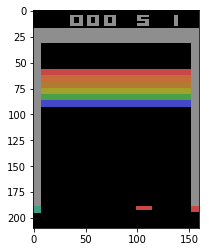

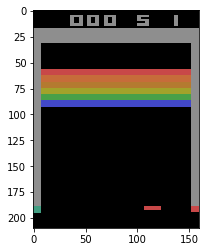

In [15]:
# print (env)
# <TimeLimit<AtariEnv<Breakout-v0>>>
# TimeLimit is env wrapper that provides ...
# max_episode_seconds, max_episode_steps
print("Action space size: {}".format(env.action_space.n))
print(env.env.get_action_meanings())

observation = env.reset()
print("Observation space shape: {}".format(observation.shape))

plt.figure()
plt.imshow(env.render(mode='rgb_array'))

[env.step(2) for x in range(1)]
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

env.render(close=True)

In [16]:
class StateProcessor():
    """
    Processes a raw Atari images. Resizes it and converts it to grayscale.
    
    It is a very interesting consideration to represent the whole system 
    as an image. It is understandable that the part corresponding to the 
    blocks should be represented like this, but 
    """
    def __init__(self):
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[210, 160, 3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            # The upper part is not relevant (there is some score)
            self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
            
            # Why resize from 160 to 84
            self.output = tf.image.resize_images(
                self.output, [84,84], 
                method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            
            self.output = tf.squeeze(self.output)
            
    def process(self, sess, state):
        """
        Args:
            sess: a Tensorflow session object
            state: A[210, 160, 3] Atari RGB state
            
        Returns:
            A processed [84, 84, 1] state representing grayscale values
        """
        return sess.run(self.output, {self.input_state: state})

In [17]:
class Estimator():
    """
    Q-Value Estimator neural network
    
    This network is used for both the Q-network and the Target Network
    """
    def __init__(self, scope="estimator", summaries_dir = None):
        self.scope = scope
        
        # Write Tensorboard summaries to disk
        self.summary_writer = None
        with tf.variable_scope(scope):
            self._build_model()
            
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)
                
    def _build_model(self):
        """
        Builds the Tensorflow graph.
        
        Network calculate Q(s,a) - action value of (state, action)
        """
        # Placeholders for our input
        # Our input are 4 RGB frames of shape 160, 160 each
        # Why 4?
        self.X_pl = tf.placeholder(shape=[None, 84, 84, 4], dtype=tf.uint8, name="X")
        # target result of the network
        self.y_pl = tf.placeholder(shape=[None],dtype=tf.uint8, name="y")
        
        self.actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")
        
        X = tf.to_float(self.X_pl) / 255.0
        
        batch_size = tf.shape(self.X_pl)[0]
        
        # This is a pretty big network
        
        # 64 filters of kernel size 8, stride of 4
        # Size reduce to (84 - 8)/4 + 1 = (20, 20, 64)
        conv1 = tf.contrib.layers.conv2d(X, 32, 8, 4, activation_fn = tf.nn.relu)
        
        # Size reduce to (20 - 4)/2 + 1 = (9, 9, 64)
        conv2 = tf.contrib.layers.conv2d(X, 64, 4, 2, activation_fn = tf.nn.relu)
        
        # Size reduce to (9 - 3)/1 + 1 = (7, 7, 64)
        conv3 = tf.contrib.layers.conv2d(X, 64, 3, 1, activation_fn = tf.nn.relu)
        
        # 7 * 7 * 64
        flattened = tf.contrib.layers.flatten(conv3)
        
        fc1 = tf.contrib.layers.fully_connected(flattened, 512)
        
        self.predictions = tf.contrib.layers.fully_connected(fc1, len(VALID_ACTIONS))
        
        # Get the predictions for the chosen actions only
        # Normally I would use the gather_2d function
        gather_indices = tf.range(batch_size) * tf.shape(self.predictions)[1] + self.actions_pl
        self.action_predictions = tf.gather(tf.reshape(self.predictions, [-1]), gather_indices)
        
        # Calcualte the loss
        self.losses = tf.squared_difference(self.y_pl, self.action_predictions)
        self.loss = tf.reduce_mean(self.losses)
        
        self.optimizer = tf.train.RMSPropOptimizer()